# Evaluating LLM Variants on the Deep Learning Domain
----
The explosive popularity of large langauge models (LLMs) since the introduction of chatGPT has brought incredible attention and enthusiasm for businesses and people in general to use and benefit from these breakthrough foundational technologies. However there still exists significant hurdles and gatekeepers to wide spread adoption of this technology. One of these is the closed source nature of OpenAI, another is the monumental computation power needed to train and deploy such a model, and finally the general concern about who's data is being used and how can you trust the information being provided. LLMs are known to confidently state things which are absolutely not factual, yet these non-facts are phrased in very absolute terms, this phenomenon is known as hallucination. 

Hallucinations are a major cause of concern as human users are not accustomed to such confident falsehoods, and generally believe something if it is presented with high levels of confidence. Hallucinations also pose major issues in business applications, where businesses cannot trust an LLM to represent them nor their products truthfully. Another area that hallucinations will hold back the adoption of these advanced tools is in education, whereby a student cannot be confident that the LLM is telling them a fact that should be noted or a complete fabrication. In this notebook we atempt to explore some potential solutions to this situation. 

## Problem statement
Large language models often suffer from hallucinations, or are largely closed source systems with unknown training data making them inaccessible and unreliable for a large number of use cases. We want to understand if "Retrieval Augmented Generation" and or "Fine Tuning" on domain specific datasets can decrease the incidence of hallucinations and improve accuracy of responses from open source LLMs.

## Project
In order to research this question we will explore the topic of building a "study buddy" who is an expert in a specific domain, and can answer questions related to the Deep Learning domain. 

### Two domain specific datasets
First we needed access to a domain specific corpus that we could help augment our base models. We obtained 5 common and publicly available textbooks in the Machine Learning and Deep learning domain. We then converted them into a text corpus containing 8605 rows, and a set of 636 question answer pairs, by using [GPT3.5-turbo](https://platform.openai.com/docs/models/gpt-3-5) to analyse the texts and create question answer pairs. 
The textbooks included were: 
- Deep Learning - Goodfellow et al
- Data Science and ML, Mathematical and Statistical Methods - Kroese et al
- Approaching (Almost) Any Machine Learning Problem - Abhishek Thakur 
- Machine Learning for Humans - Maini et al   
- Mathematics for Machine Learning - Deisenroth et al


### Baseline Question answering performance from two Open Source LLMs
We looked at the [Falcon-7B-Instruct model](https://huggingface.co/tiiuae/falcon-7b-instruct), as it performs well on public benchmarks as the basis for SOTA methods in the open source community. We also looked at GPT2, as a smaller simpler model that is lightweight and easy to finetune. Specifically we looked at [distilGPT2](https://huggingface.co/distilgpt2) a re-engineered open source version of GPT2 that is trained on [OpenWebText](https://huggingface.co/datasets/Skylion007/openwebtext)

### Finetuning vs Retrival Augmented Generation
We looked at two methods of introducing domain specific data and decreasing hallucination; finetuning and retrival augmented generation (RAG). 

For both base models we applied the same finetuning approach. Initially we finetuned the models on the [textbook corpus](https://huggingface.co/datasets/mjphayes/textbook_dataset), then to re-align the model to the nature of our intended prompting we ran a small finetuning training on roughly 20% of the [custom question answer pairs](https://huggingface.co/datasets/mjphayes/machine_learning_questions)

For the RAG approach, we ingested the text corpus of the text books into a vector store, by tokenizing and converting overlapping chunks of text into vector emmbeddings, which were then searchable for semantic similarity with the presented question. When the question is presented, it is tokenised in the same way and the most similar chunks of text are presented to the model as part of the prompt. This allows the model to essentially "get the answers" before needing to generate an answer to the question. 

Unfortunately there wasn't a suitable adapter for the GPT2 model, so this technique was only applied to the Falcon model.

## This Notebook - How to use
You can run this notebook top to bottom, although it will need to down load the datasets and the falcon model, which are large and take a lot of time. Inference over the evaluation questions also takes approximately 1 hour per model (less on GPT2 more on Falcon). So running this notebook top to bottom will take you ~6-8 hours including training times. Not recommended. Instead, the datasets and results have already been run and their outputs are visible. You can also run just the results section, which will download the precomputed CSV's of the results from a github Gist. 

With that said, all the datasources can be downloaded and ran from within the notebook, it will also create a cache and directory structure, so if you do download a model to machine that can run the models then it will cache it to prevent you from needing to run it again. 

### Set up the notebook environment

In [1]:
# !pip install -q -U bitsandbytes
# !pip install -q -U pip
# !pip install -q -U datasets
# !pip install -q -U accelerate
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U einops
# !pip install -q -U safetensors
# !pip install -q -U torch
# !pip install -q -U xformers
# !pip install -q -U langchain
# !pip install -q -U pypdf
# !pip install -q -U pymupdf
# !pip install -q -U faiss-gpu
# !pip install -q -U bert_score
# !pip install -q -U spacy
# !pip install -q typing-inspect==0.8.0
# !pip install -q typing_extensions==4.5.0
# !pip install -q pydantic==1.10.11

In [2]:
import os
import logging
import transformers
import bert_score
import torch
import pandas as pd
import bitsandbytes as bnb
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import rcParams
from bert_score import score, BERTScorer
from datasets import load_dataset
from operator import itemgetter
from langchain import HuggingFacePipeline
from langchain import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader, DirectoryLoader
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    pipeline,
)

## just to suppress warnings for things like not running on GPU when using langchain
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else :
    device = torch.device('cpu')

device

device(type='cuda')

In [145]:
import os

### Set up constants to manage local storage and retrieve models and data

In [3]:
PROJECT_ROOT = '.'
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

PDF_DIR = os.path.join(PROJECT_ROOT, DATA_DIR, 'pdfs')
TEXT_DIR = os.path.join(PROJECT_ROOT, DATA_DIR, 'texts')

MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

TRAIN_DATA_SOURCE = 'mjphayes/textbook_dataset'
TRAIN_DATA_CACHE = os.path.join(PROJECT_ROOT, DATA_DIR, 'textbook-dataset')

EVAL_DATA_SOURCE = 'mjphayes/machine_learning_questions'
EVAL_DATA_CACHE = os.path.join(PROJECT_ROOT, DATA_DIR, 'machine-learning-questions')

GPT2_CHECKPOINT = 'distilgpt2'
GPT2_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, GPT2_CHECKPOINT)

GPT2_FINETUNE_CHECKPOINT = 'mjphayes/distilgpt2-finetuned-textbook_dataset'
GPT2_FINETUNE_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'distilgpt2-finetuned-textbook_dataset')

FALCON_CHECKPOINT = "vilsonrodrigues/falcon-7b-instruct-sharded"
FALCON_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'falcon-7b-instruct')

FALCON_FINETUNE_CHECKPOINT = 'mjphayes/falcon-7b-instruct-textbook_dataset'
FALCON_FINETUNE_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'falcon-7b-instruct-textbook_dataset')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
if not os.path.exists(PDF_DIR):
    os.makedirs(PDF_DIR)
if not os.path.exists(TEXT_DIR):
    os.makedirs(TEXT_DIR)

In [149]:
# HF_TOKEN = os.environ.get('HF_TOKEN')

## Generating the two custom domain specific datasets

In [5]:
!wget https://everythingcomputerscience.com/books/Machine%20Learning%20for%20Humans.pdf -P $PDF_DIR
!wget https://mml-book.github.io/book/mml-book.pdf -P $PDF_DIR
!wget https://github.com/abhishekkrthakur/approachingalmost/raw/master/AAAMLP.pdf -P $PDF_DIR
!wget https://people.smp.uq.edu.au/DirkKroese/DSML/DSML.pdf -P $PDF_DIR
!wget https://raw.githubusercontent.com/janishar/mit-deep-learning-book-pdf/master/complete-book-pdf/deeplearningbook.pdf -P $PDF_DIR

--2023-11-19 01:45:25--  https://everythingcomputerscience.com/books/Machine%20Learning%20for%20Humans.pdf
Resolving everythingcomputerscience.com (everythingcomputerscience.com)... 66.96.149.32
Connecting to everythingcomputerscience.com (everythingcomputerscience.com)|66.96.149.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15473464 (15M) [application/pdf]
Saving to: ‘././data/pdfs/Machine Learning for Humans.pdf’

Machine Learning fo 100%[===================>]  14.76M  78.9MB/s    in 0.2s    

2023-11-19 01:45:25 (78.9 MB/s) - ‘././data/pdfs/Machine Learning for Humans.pdf’ saved [15473464/15473464]

--2023-11-19 01:45:26--  https://mml-book.github.io/book/mml-book.pdf
Resolving mml-book.github.io (mml-book.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to mml-book.github.io (mml-book.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17566161 (17M) [application/pdf]
Savi

### Extracting raw text from the textbooks

In [ ]:
def extract_pdf_text(filename):
    file = open(filename, 'rb')
    reader = PyPDF2.PdfReader(file)
    text = ''
    for page in range(len(reader.pages)):
        page = reader.pages[page]
        text += page.extract_text()
    return text

In [ ]:
def extract_pdf_text_from_dir(dir):
    text = ''
    for filename in glob.glob(os.path.join(PDF_DIR, '*.pdf')):
        text += extract_pdf_text(filename) + '\n\n\n\n\n'
    return text

In [ ]:
texts = extract_pdf_text_from_dir(PDF_DIR)
file = open(os.path.join(TEXT_DIR, 'combined_textbooks.txt'), 'w')
file.write(texts)

### Creating the huggingface datasets datamodel from the raw text

In [ ]:
dataset = load_dataset('text', data_files=os.path.join(TEXT_DIR, 'combined_textbooks.txt'))
dataset

In [ ]:
# dataset.push_to_hub(TRAIN_DATA_SOURCE, use_auth_token=HF_TOKEN)

In [4]:
path_to_texts = os.path.join(DATA_DIR, 'textbooks.txt')
try:
    text_books = open(path_to_texts, 'r', encofing="utf-8").read()
except:
    !wget 'https://gist.githubusercontent.com/mitchelljphayes/82de40eb4ec9275c9b3403fa53665fde/raw/88b0d35d78b4b65d02384980b3e106f20767f7c6/textbooks.txt' -P $DATA_DIR
    text_books = open(path_to_texts, 'r', encoding="utf-8").read()

--2023-11-19 04:59:04--  https://gist.githubusercontent.com/mitchelljphayes/82de40eb4ec9275c9b3403fa53665fde/raw/88b0d35d78b4b65d02384980b3e106f20767f7c6/textbooks.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 703532 (687K) [text/plain]
Saving to: ‘./data/textbooks.txt.6’

textbooks.txt.6     100%[===================>] 687.04K  --.-KB/s    in 0.008s  

2023-11-19 04:59:04 (79.1 MB/s) - ‘./data/textbooks.txt.6’ saved [703532/703532]



## Creating the custom Question Answer dataset

In [ ]:
path_to_questions = os.path.join(DATA_DIR, 'machine-learning-questions.json')
try:
    questions = pd.read_json(path_to_questions)
except:
    !wget https://gist.githubusercontent.com/mitchelljphayes/7cb8fafc2959f2ef2d54020e70ff5283/raw/f93ca8dd70378fb434fa5acb3fc69e27ed54b05e/machine-learning-questions.json -P $DATA_DIR
    questions = pd.read_json(path_to_questions)

## Evaluating sentence similarity evaluations using BertScore


In [6]:
scorer = BERTScorer(lang="en")
def evaluate_answers(dataset, generated_answers, scorer=scorer):
    ideal = dataset['answer']
    P, R, F1 = scorer.score(ideal, generated_answers)
    df = pd.DataFrame({'question': dataset['question'], 'ideal': ideal, 'generated': generated_answers, 'P': P, 'R': R, 'F1': F1})
    return df

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Falcon 7 B

### Initialising the baseline falcon-7b-instruct model

In [7]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [8]:
falcon_4bit = AutoModelForCausalLM.from_pretrained(
        FALCON_CHECKPOINT,
        device_map='auto',
        quantization_config=quantization_config,
        cache_dir=FALCON_CACHE_DIR,
        )
falcon_tokenizer = AutoTokenizer.from_pretrained(FALCON_CHECKPOINT, cache_dir=FALCON_CACHE_DIR)

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
falcon_tokenizer.pad_token = falcon_tokenizer.eos_token

In [9]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [10]:
falcon_4bit.gradient_checkpointing_enable()
falcon_4bit = prepare_model_for_kbit_training(falcon_4bit)

In [10]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

falcon_4bit = get_peft_model(falcon_4bit, config)
print_trainable_parameters(falcon_4bit)

trainable params: 4718592 || all params: 3613463424 || trainables%: 0.13058363808693696


In [14]:
    generation_config = falcon_4bit.generation_config
    generation_config.max_new_tokens = 312
    generation_config.temperature = 0.7
    generation_config.top_p = 0.7
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = falcon_tokenizer.eos_token_id
    generation_config.eos_token_id = falcon_tokenizer.eos_token_id

In [15]:
prompt = """
Question: What is machine learning?
Answer:
""".strip()
%time
encoding = falcon_tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = falcon_4bit.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(falcon_tokenizer.decode(outputs[0], skip_special_tokens=True))

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 8.82 µs


The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecated in the future in favor of the `BetterTransformer` API. Please install the latest optimum library with `pip install -U optimum` and call `model.to_bettertransformer()` to benefit from `torch.scaled_dot_product_attention` and future performance optimizations.


Question: What is machine learning?
Answer: Machine learning is a branch of artificial intelligence that focuses on the development of computer programs that can learn from data and improve their performance over time. It involves the use of algorithms to analyze data and make predictions or decisions based on the analysis.


## Evaluating the baseline falcon model

In [34]:
def falcon_inference(question, model, tokenizer, device):
    prompt = f"""
    Question: {question}
    Answer:
    """.strip()
    generation_config = model.generation_config
    generation_config.max_new_tokens = 312
    generation_config.temperature = 0.7
    generation_config.top_p = 0.7
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id

    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids = encoding.input_ids,
          attention_mask = encoding.attention_mask,
          generation_config = generation_config
      )
    initial_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = initial_answer.split('Answer:')[-1]
    return answer.strip()

In [26]:
def run_evaluation(evaluation_dataset, inference_function, model, tokenizer, device):
    results = []
    for i in tqdm(range(len(evaluation_dataset))):
        question = evaluation_dataset[i]['question']
        answer = inference_function(question, model, tokenizer, device)
        results.append(answer)
    return results

In [18]:
eval_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='train')

In [19]:
answer = falcon_inference('What is machine learning?', falcon_4bit, falcon_tokenizer, device)
answer

'Machine learning is a branch of artificial intelligence that focuses on the development of computer programs that can learn from data and improve their performance over time. It involves the use of algorithms to analyze data and make predictions or decisions based on the analysis.'

In [20]:
falcon_answers = run_evaluation(eval_data, falcon_inference, falcon_4bit, falcon_tokenizer, device)

100%|██████████| 508/508 [22:33<00:00,  2.66s/it]


In [21]:
falcon_results = evaluate_answers(eval_data, falcon_answers)
falcon_results.to_csv(os.path.join(RESULTS_DIR, 'falcon_results.csv'))

## Fine tuning falcon

In [18]:
textbook_dataset = load_dataset(TRAIN_DATA_SOURCE, cache_dir=TRAIN_DATA_CACHE)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8605 [00:00<?, ? examples/s]

In [19]:
def tokenize_for_falcon(examples):
    return falcon_tokenizer(examples["text"])

In [20]:
tokenized_text = textbook_dataset.map(tokenize_for_falcon, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/8605 [00:00<?, ? examples/s]

In [21]:
split_data = tokenized_text['train'].train_test_split(test_size=0.05)

In [22]:
block_size = falcon_tokenizer.model_max_length
# block_size = 128
block_size

2048

In [23]:
def group_inputs(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [24]:
grouped_data = split_data.map(
    group_inputs,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/8174 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/431 [00:00<?, ? examples/s]

In [25]:
grouped_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 93
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4
    })
})

In [26]:
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=8,
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=3,
    logging_steps=1,
    output_dir="experiments",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
)

trainer = Trainer(
    model=falcon_4bit,
    train_dataset=grouped_data['train'],
    eval_dataset=grouped_data['test'],
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(falcon_tokenizer, mlm=False)
)
falcon_4bit.config.use_cache = False

In [27]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,2.676100,2.413958
1,2.346700,2.290627
2,2.418400,2.228009
4,2.275700,2.171650
5,2.045300,2.161940
6,1.968200,2.158925
7,2.025900,2.158087


TrainOutput(global_step=184, training_loss=2.3328212259904197, metrics={'train_runtime': 1645.9774, 'train_samples_per_second': 0.452, 'train_steps_per_second': 0.112, 'total_flos': 5.997028265951232e+16, 'train_loss': 2.3328212259904197, 'epoch': 7.91})

In [28]:
trainer.save_model(FALCON_FINETUNE_CHECKPOINT)

In [29]:
try:
    falcon_finetune = falcon_4bit
except:
    falcon_finetune = AutoModelForCausalLM.from_pretrained(
        FALCON_FINETUNE_CHECKPOINT,
        quantization_config=quantization_config,
        cache_dir=FALCON_FINETUNE_CACHE_DIR,
        device_map='auto'
        )

In [30]:
def generate_prompt(data_point):
  return f"""
Question: {data_point["question"]}
Answer: {data_point["answer"]}
""".strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = falcon_tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt

In [75]:
alignment_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='test')

In [32]:
alignment_data = alignment_data.map(generate_and_tokenize_prompt).remove_columns(['question', 'answer']).train_test_split(test_size=0.05)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [33]:
alignment_data

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 121
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 7
    })
})

In [34]:
alignment_trainer = transformers.Trainer(
    model=falcon_finetune,
    train_dataset=alignment_data['train'],
    eval_dataset=alignment_data['test'],
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(falcon_tokenizer, mlm=False)
)
falcon_finetune.config.use_cache = False

In [35]:
alignment_trainer.train()

Epoch,Training Loss,Validation Loss
0,1.725500,1.734059
1,1.583600,1.657624
2,1.188300,1.666267
4,0.896700,1.881637
5,0.848800,2.029386
6,0.741300,2.117304
7,0.625300,2.116161


TrainOutput(global_step=240, training_loss=1.0481980342417956, metrics={'train_runtime': 318.7197, 'train_samples_per_second': 3.037, 'train_steps_per_second': 0.753, 'total_flos': 1823304624952320.0, 'train_loss': 1.0481980342417956, 'epoch': 7.93})

In [72]:
falcon_finetune.save_pretrained(FALCON_FINETUNE_CACHE_DIR)
falcon_tokenizer.save_pretrained(FALCON_FINETUNE_CACHE_DIR)
# falcon_finetune.push_to_hub(FALCON_FINETUNE_CHECKPOINT, token=HF_TOKEN)
# falocn_tokenizer.push_to_hub(FALCON_FINETUNE_CHECKPOINT, token=HF_TOKEN)

CommitInfo(commit_url='https://huggingface.co/mjphayes/falcon-7b-instruct-textbook_dataset/commit/489a117d0b22c6dc3a88f6870832be170a4ec085', commit_message='Upload model', commit_description='', oid='489a117d0b22c6dc3a88f6870832be170a4ec085', pr_url=None, pr_revision=None, pr_num=None)

We now reload the model into memory, so that it is configured for inference, and we have a point at which we can run the notebook, to skip the training step.

In [22]:
falcon_finetune = AutoModelForCausalLM.from_pretrained(FALCON_FINETUNE_CHECKPOINT, cache_dir=FALCON_FINETUNE_CACHE_DIR, device_map='auto', quantization_config=quantization_config)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/828M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

### Evaluating the finetuned falcon model

In [31]:
prompt = """
Questin: What is an LSTM?
Answer:
""".strip()

encoding = falcon_tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
# with torch.no_grad():
  outputs = falcon_finetune.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )
print(falcon_tokenizer.decode(outputs[0], skip_special_tokens=True))

Questin: What is an LSTM?
Answer: An LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is used in deep learning for various tasks like language modeling, speech recognition, and text summarization. (Gureviews.org) --- \pagepagecount\pagepagecount+1 iCLASS (input, class labels), --- "Deep Learning (AL): A Deep Perspective", p. AL. " deep.pdf........pdf (PDF with page number)... row numbers in each row contain a row number and the corresponding element in the row contains a float column with the same number. row = 10 (C) \Input{Automatically generated} m_1, m_2..pdf.pdf (PDF with page numbers)...alldata. (AL): All, Astronomy, Life..pdf (AL: Astronomy)..xlsx | row indices (i) with lengths j=1,2,3, etc. columns (c) with widths c1,c2,c3 with widths p1,p2,p3.pdf  float(m).xlsx (Excel file with all rows) m_1, m_2, m_3


In [33]:
answer = falcon_inference("What is an LSTM", falcon_finetune, falcon_tokenizer, device)
answer

'Question: What is an LSTM\n    Answer: Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture used in deep learning for natural language processing tasks like language modeling, translation, and sentiment analysis....x.train.pdf (training set)....predict (predictor)..,.page_count + 1 (page numbers).. of file i (i. name). [X] election_results = [X(i) for i in X]...X.train_data = training_data...X.train_labels = [i for i in X] (training set)...X.train_labels = [i for i in X] (training set)...X.train_weights = [weights for weights in X] (training weights)...X.train_weights = weights[X]...X.train_ losses =...X.train_losses = [i for i in X]...X.train_losses = [i for i in X] in train_weights]...X.train_weights = [i for i in X] in train_weights]...X.train_weights'

In [35]:
falcon_finetune_answers = run_evaluation(eval_data, falcon_inference, falcon_finetune, falcon_tokenizer, device)

100%|██████████| 508/508 [1:08:55<00:00,  8.14s/it]


In [39]:
falcon_finetune_results = evaluate_answers(eval_data, falcon_finetune_answers)
falcon_finetune_results.to_csv(os.path.join(RESULTS_DIR, 'falcon_finetune_results.csv'))

In [37]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Loading GPT2

In [ ]:
gpt2 = AutoModelForCausalLM.from_pretrained(GPT2_CHECKPOINT, cache_dir=GPT2_CACHE_DIR)
gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_CHECKPOINT, cache_dir=GPT2_CACHE_DIR, use_fast=True)

In [ ]:
gpt2.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
special_tokens_dict = {'eos_token': '<|endoftext|>'}
num_added_toks = gpt2_tokenizer.add_special_tokens(special_tokens_dict)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2.resize_token_embeddings(len(gpt2_tokenizer))

Embedding(50257, 768)

In [ ]:
def gpt2_inference(question, model, tokenizer, device):
    prompt = f"""
    Question: {question} \n
    Answer:
    """.strip()
    model_inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generated_tokens = model.generate(**model_inputs, max_length=512)
    response = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    answer = response.split('Answer:')[-1]
    return answer.strip()

In [ ]:
answer = gpt2_inference("Explain how neural networks work", gpt2, gpt2_tokenizer, device)
answer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


' How neural networks work \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

In [ ]:
gpt2_answers = run_evaluation(eval_data, gpt2_inference, gpt2, gpt2_tokenizer, device)

100%|██████████| 508/508 [21:36<00:00,  2.55s/it]


In [ ]:
gpt2_results = evaluate_answers(eval_data, gpt2_answers)
gpt2_results.to_csv(os.path.join(RESULTS_DIR, 'gpt2_results.csv'))

# Finetuning GPT2

In [ ]:
textbook_dataset = load_dataset(TRAIN_DATA_SOURCE, cache_dir=TRAIN_DATA_CACHE)
textbook_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8605
    })
})

In [ ]:
def tokenize_for_gpt2(examples):
    return gpt2_tokenizer(examples["text"])

In [ ]:
gpt2_tokenized_text = textbook_dataset.map(tokenize_for_gpt2, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/8605 [00:00<?, ? examples/s]

In [ ]:
block_size = gpt2_tokenizer.model_max_length
block_size

1024

In [ ]:
def group_inputs(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
grouped_text_data = gpt2_tokenized_text.map(
    group_inputs,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/8605 [00:00<?, ? examples/s]

In [ ]:
grouped_text_data = grouped_text_data['train'].train_test_split(test_size=0.05, shuffle=True)

In [ ]:
training_args = TrainingArguments(
    GPT2_FINETUNE_CACHE_DIR,
    evaluation_strategy="epoch",
    num_train_epochs=8,
    learning_rate=2e-4,
    weight_decay=0.01,
)
trainer = Trainer(
    model=gpt2,
    args=training_args,
    train_dataset=grouped_text_data['train'],
    eval_dataset=grouped_text_data['test'],
    data_collator=DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False),
)


In [ ]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.823337
2,No log,2.694608
3,No log,2.637865
4,No log,2.622104
5,No log,2.606122
6,No log,2.604398
7,No log,2.595467
8,No log,2.595535


TrainOutput(global_step=176, training_loss=2.594655297019265, metrics={'train_runtime': 26.8882, 'train_samples_per_second': 51.175, 'train_steps_per_second': 6.546, 'total_flos': 359544328814592.0, 'train_loss': 2.594655297019265, 'epoch': 8.0})

In [ ]:
def transform_for_q_and_a(examples):
    return {"text": f"Question: {examples['question']} \n Answer: {examples['answer']}"}

In [ ]:
trainer.save_model(GPT2_FINETUNE_CACHE_DIR)
gpt2_tokenizer.save_pretrained(GPT2_FINETUNE_CACHE_DIR)
gpt2_finetune = AutoModelForCausalLM.from_pretrained(GPT2_FINETUNE_CHECKPOINT, cache_dir=GPT2_FINETUNE_CACHE_DIR)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [ ]:
alignment_data = (load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='test')
                    .train_test_split(test_size=0.1, shuffle=True)
                    .map(transform_for_q_and_a, num_proc=4)
                    .map(tokenize_for_gpt2, batched=True, num_proc=4, remove_columns=["text"])
                    )



Map (num_proc=4):   0%|          | 0/115 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/13 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/115 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/13 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    GPT2_FINETUNE_CACHE_DIR,
    evaluation_strategy="epoch",
    num_train_epochs=8,
    learning_rate=2e-4,
    weight_decay=0.01,
)
alignment_trainer = Trainer(
    model=gpt2_finetune,
    args=training_args,
    train_dataset=alignment_data['train'],
    eval_dataset=alignment_data['test'],
    data_collator=DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False),
)

In [ ]:
alignment_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.099357
2,No log,2.107676
3,No log,2.170061
4,No log,2.346815
5,No log,2.467667
6,No log,2.567418
7,No log,2.631538
8,No log,2.649171


TrainOutput(global_step=120, training_loss=0.9918667475382487, metrics={'train_runtime': 3.6986, 'train_samples_per_second': 248.746, 'train_steps_per_second': 32.445, 'total_flos': 15830653427712.0, 'train_loss': 0.9918667475382487, 'epoch': 8.0})

In [ ]:
alignment_trainer.save_model(GPT2_FINETUNE_CACHE_DIR)
gpt2_tokenizer.save_pretrained(GPT2_FINETUNE_CACHE_DIR)

('././models/mjphayes/distilgpt2-finetuned-textbook_dataset/tokenizer_config.json',
 '././models/mjphayes/distilgpt2-finetuned-textbook_dataset/special_tokens_map.json',
 '././models/mjphayes/distilgpt2-finetuned-textbook_dataset/vocab.json',
 '././models/mjphayes/distilgpt2-finetuned-textbook_dataset/merges.txt',
 '././models/mjphayes/distilgpt2-finetuned-textbook_dataset/added_tokens.json',
 '././models/mjphayes/distilgpt2-finetuned-textbook_dataset/tokenizer.json')

In [ ]:
# gpt2.push_to_hub(GPT2_FINETUNE_CHECKPOINT, use_auth_token=HF_TOKEN)
# gpt2_tokenizer.push_to_hub(GPT2_FINETUNE_CHECKPOINT, use_auth_token=HF_TOKEN)

/usr/local/lib/python3.9/dist-packages/transformers/utils/hub.py:857: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/utils/hub.py:857: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/mjphayes/distilgpt2-finetuned-textbook_dataset/commit/5f0477a1822542c26f18e426034b80652055404f', commit_message='Upload tokenizer', commit_description='', oid='5f0477a1822542c26f18e426034b80652055404f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
gpt2_finetune = AutoModelForCausalLM.from_pretrained(GPT2_FINETUNE_CHECKPOINT, cache_dir=GPT2_FINETUNE_CACHE_DIR).to(device)

In [ ]:
gpt2_finetune_answers = run_evaluation(eval_data, gpt2_inference, gpt2_finetune, gpt2_tokenizer, device)

100%|██████████| 508/508 [20:28<00:00,  2.42s/it]


In [ ]:
gpt2_finetune_results = evaluate_answers(eval_data, gpt2_finetune_answers)
gpt2_finetune_results.to_csv(os.path.join(RESULTS_DIR, 'gpt2_finetune_results.csv'))

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Loading falcon for RAG

In [ ]:
rag_quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
falcon_4bit_rag = AutoModelForCausalLM.from_pretrained(
        FALCON_CHECKPOINT,
        device_map='auto',
        quantization_config=rag_quantization_config,
        cache_dir=FALCON_CACHE_DIR,
        )
falcon_tokenizer_rag = AutoTokenizer.from_pretrained(FALCON_CHECKPOINT, cache_dir=FALCON_CACHE_DIR)

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
rag_pipeline = pipeline(
        "text-generation",
        model=falcon_4bit_rag,
        tokenizer=falcon_tokenizer_rag,
        use_cache=True,
        device_map="auto",
        max_length=2048,
        do_sample=True,
        top_k=3,
        num_return_sequences=1,
        eos_token_id=falcon_tokenizer_rag.eos_token_id,
        pad_token_id=falcon_tokenizer_rag.eos_token_id,
)

In [6]:
text_books = open(path_to_texts, 'r', encoding="utf-8").read()

In [ ]:
rag_falcon = HuggingFacePipeline(pipeline=rag_pipeline)
rag_embeddings = HuggingFaceEmbeddings()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=48,
    length_function=len,
    add_start_index=False,
)

In [7]:
text_books = text_books.strip()
text_books

'MATHEMATICS FOR MACHINE LEARNING \nMarc Peter Deisenroth \nA. Aldo Faisal \nCheng Soon Ong\nContents \nForeword 1 \nPart I Mathematical Foundations 9 \n1 Introduction and Motivation 11 1.1 Finding Words for Intuitions 12 1.2 Two Ways to Read This Book 13 1.3 Exercises and Feedback 16 \n2 Linear Algebra 17 2.1 Systems of Linear Equations 19 2.2 Matrices 22 2.3 Solving Systems of Linear Equations 27 2.4 Vector Spaces 35 2.5 Linear Independence 40 2.6 Basis and Rank 44 2.7 Linear Mappings 48 2.8 Affine Spaces 61 2.9 Further Reading 63 Exercises 64 \n3 Analytic Geometry 70 3.1 Norms 71 3.2 Inner Products 72 3.3 Lengths and Distances 75 3.4 Angles and Orthogonality 76 3.5 Orthonormal Basis 78 3.6 Orthogonal Complement 79 3.7 Inner Product of Functions 80 3.8 Orthogonal Projections 81 3.9 Rotations 91 3.10 Further Reading 94 Exercises 96 \n4 Matrix Decompositions 98 4.1 Determinant and Trace 99 \ni \nThis material is published by Cambridge University Press as Mathematics for Machine Learnin

In [14]:
texts = text_splitter.create_documents([text_books])

In [12]:
embeddings = HuggingFaceEmbeddings()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [15]:
vector_store = FAISS.from_documents(texts, embeddings)
vector_store.save_local('./storage/vector_store')
vector_store = FAISS.load_local('./storage/vector_store', embeddings)
retriever = vector_store.as_retriever()

In [ ]:
search = vector_store.similarity_search("What is a neural network?", k=3)
source = search[0].page_content
source

'The quintessential example of a deep learning model is the feedforward deep network or multilayer perceptron (MLP). A multilayer perceptron is just a mathematical function mapping some set of input values to output values. The function is formed by composing many simpler functions. We can think of each application of a different mathematical function as providing a new representation of the input.'

In [ ]:
answer = retriever.get_relevant_documents("What is a neural network?", k=1)

In [ ]:
answer

[Document(page_content='The quintessential example of a deep learning model is the feedforward deep network or multilayer perceptron (MLP). A multilayer perceptron is just a mathematical function mapping some set of input values to output values. The function is formed by composing many simpler functions. We can think of each application of a different mathematical function as providing a new representation of the input.'),
 Document(page_content='But really, this is a giant mathematical equation with millions of terms and lots of  parameters. The input X is, say, a greyscale image represented by a w-by-h matrix of  pixel brightnesses. The output Y is a vector of class probabilities. This means we have  as an output the probability of each class being the correct label. If this neural net is  working well, the highest probability should be for the correct class. And the layers in  the middle are just doing a bunch of matrix multiplication by summing'),
 Document(page_content='F\n1940 1

In [ ]:
template = """Answer the question based only on the context provided bellow:

INSTRUCTIONS:
Ensure that the answer is grammatically correct and relevant to the context.
DO NOT include any HTML tags in your answer.
DO NOT include any information that is not directly relevant to the question.
Be succinct and to the point. Keep your answer to one or two sentences.

Context: {context}


Question: {question}


Answer:"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | rag_falcon
    | StrOutputParser()
)

In [28]:
eval_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='train')

In [29]:
eval_data

Dataset({
    features: ['question', 'answer', '__index_level_0__'],
    num_rows: 508
})

In [ ]:
from random import randint
rand = randint(0, len(eval_data))
random_question = eval_data[rand]['question']
ideal_answer = eval_data[rand]['answer']
print(random_question)
generated_answer = chain.invoke({"question": random_question})
generated_answer = generated_answer.split('Answer: ')[-1].strip().split('\n')[0]
print(generated_answer)
print("="*86)
print(ideal_answer)

What is 'stochastic gradient descent' (SGD) in machine learning?
'stochastic gradient descent' in machine learning is a common optimization algorithm used to learn the parameters of neural networks. It involves the use of a learning rate that adjusts the weights of the neural network based on a gradient calculation. Gradient descent is a mathematical optimization algorithm used in machine learning to find the minimum value of a function. In SGD, the gradient calculation is used for the weight updates of the neural network. Gradient descent is used to update the weights of a neural network to minimize a loss function. The learning rate is typically set to a small number, such as 0.1, to allow for fast convergence to the minimum value of the loss function.
Stochastic gradient descent (SGD) in machine learning is an iterative method for optimizing an objective function with suitable smoothness properties, particularly for large-scale and sparse machine learning problems.


In [ ]:
def rag_inference(question, model, tokenizer, device):
    chain = model
    response = chain.invoke({"question": question})
    answer = response.split('Answer: ')[-1].strip().split('\n')[0]
    return answer

In [ ]:
rag_answers = run_evaluation(eval_data, rag_inference, chain, falcon_tokenizer_rag, device)

100%|██████████| 508/508 [54:29<00:00,  6.44s/it]  


In [ ]:
rag_results = evaluate_answers(eval_data, rag_answers)
rag_results.to_csv(os.path.join(RESULTS_DIR, 'rag_results.csv'))

# Results

In [36]:
import numpy as np

In [ ]:
gpt2_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gpt2_results.csv'))
gpt2_finetune_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gpt2_finetune_results.csv'))
falcon_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'falcon_results.csv'))
falcon_finetune_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'falcon_finetune_results.csv'))
rag_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'rag_results.csv'))

In [37]:
def print_summary(df, model_name):
    print(f"{model_name:20s} Mean Precision: {df['P'].mean()}")
    print(f"{model_name:20s} Mean Recall:    {df['R'].mean()}")
    print(f"{model_name:20s} Mean F1:        {df['F1'].mean()}")

In [38]:
models_with_results = {
    'GPT2': gpt2_results_df,
    'GPT2 Finetuned': gpt2_finetune_results_df,
    'FALCON': falcon_results_df,
    'FALCON Finetuned': falcon_finetune_results_df,
    'RAG': rag_results_df
}

In [39]:
for model_name, results_df in models_with_results.items():
    print("="*55)
    print_summary(results_df, model_name)
    print()

GPT2                 Mean Precision: 0.7444586824015748
GPT2                 Mean Recall:    0.6856828544488188
GPT2                 Mean F1:        0.7117185585826771

GPT2 Finetuned       Mean Precision: 0.48040724458661416
GPT2 Finetuned       Mean Recall:    0.474265110511811
GPT2 Finetuned       Mean F1:        0.4763223158464567

FALCON               Mean Precision: 0.8964403807874015
FALCON               Mean Recall:    0.8840705547244094
FALCON               Mean F1:        0.8898986018307087

FALCON Finetuned     Mean Precision: 0.8796251982283464
FALCON Finetuned     Mean Recall:    0.8074321935433071
FALCON Finetuned     Mean F1:        0.8404417248031497

RAG                  Mean Precision: 0.8948293111220472
RAG                  Mean Recall:    0.8682503328346457
RAG                  Mean F1:        0.8809914010629921



In [40]:
def show_f1_scores(df, model_name):
    plt.figure(figsize=(12, 8))
    plt.hist(df['F1'], bins=100)
    plt.title(f"{model_name} F1 Scores")
    plt.style.use('ggplot')
    plt.show()

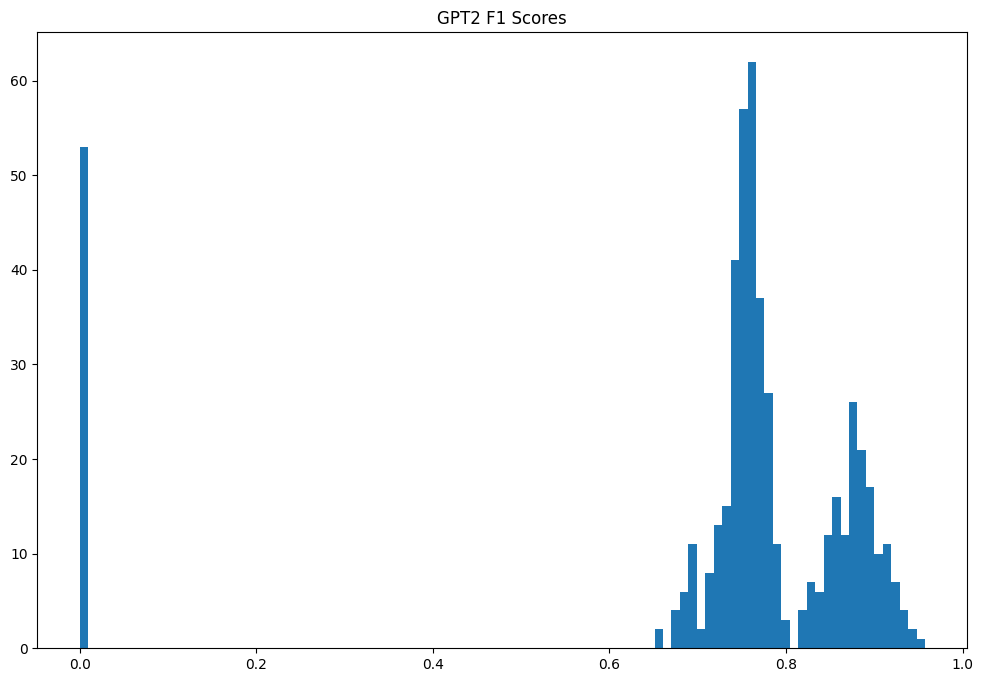

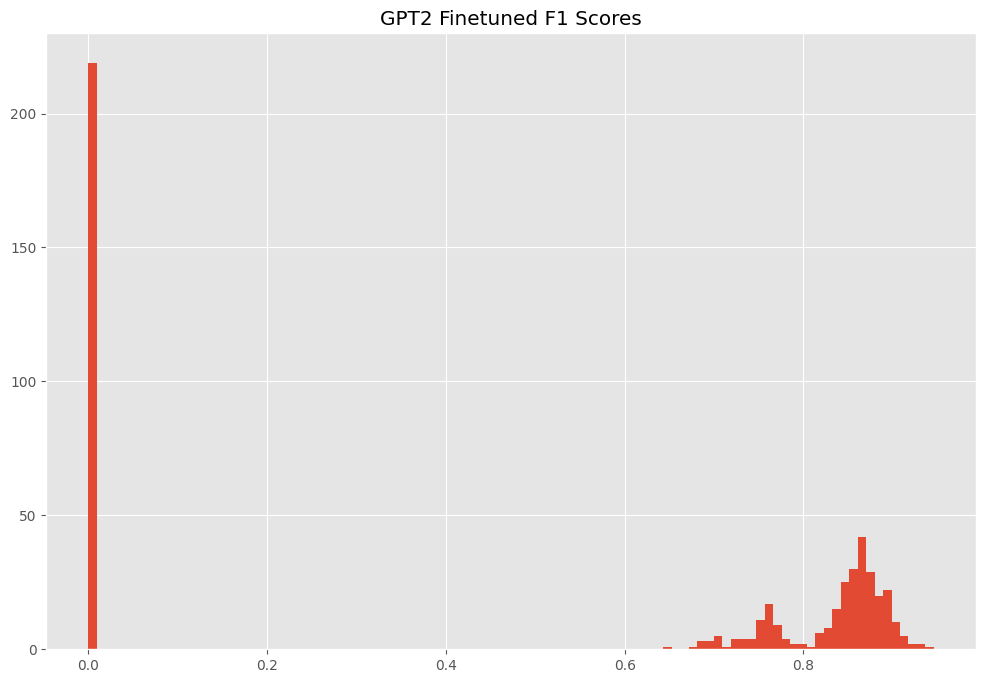

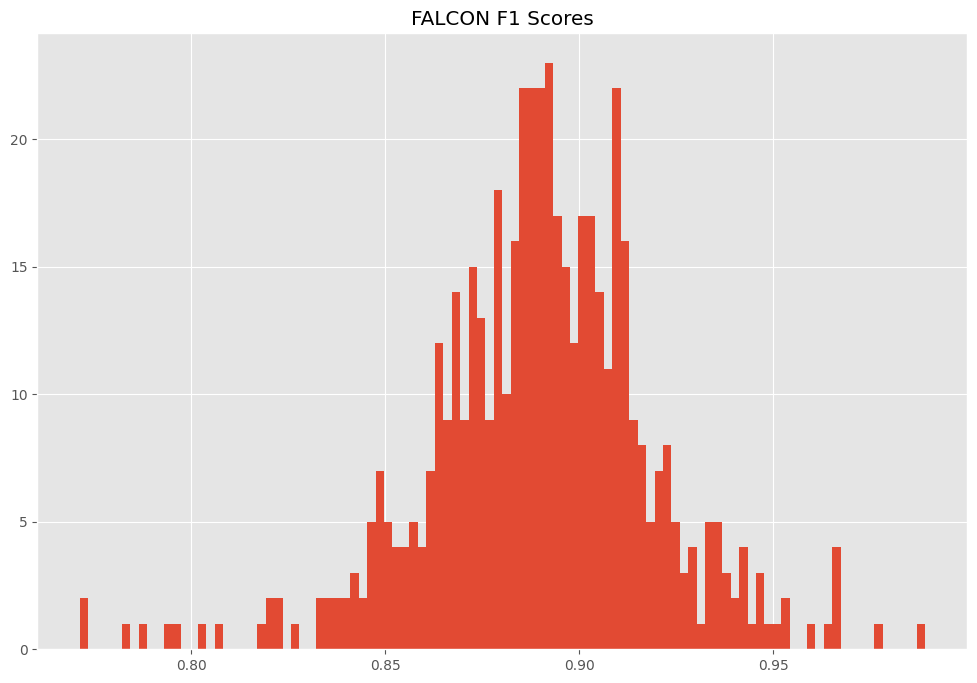

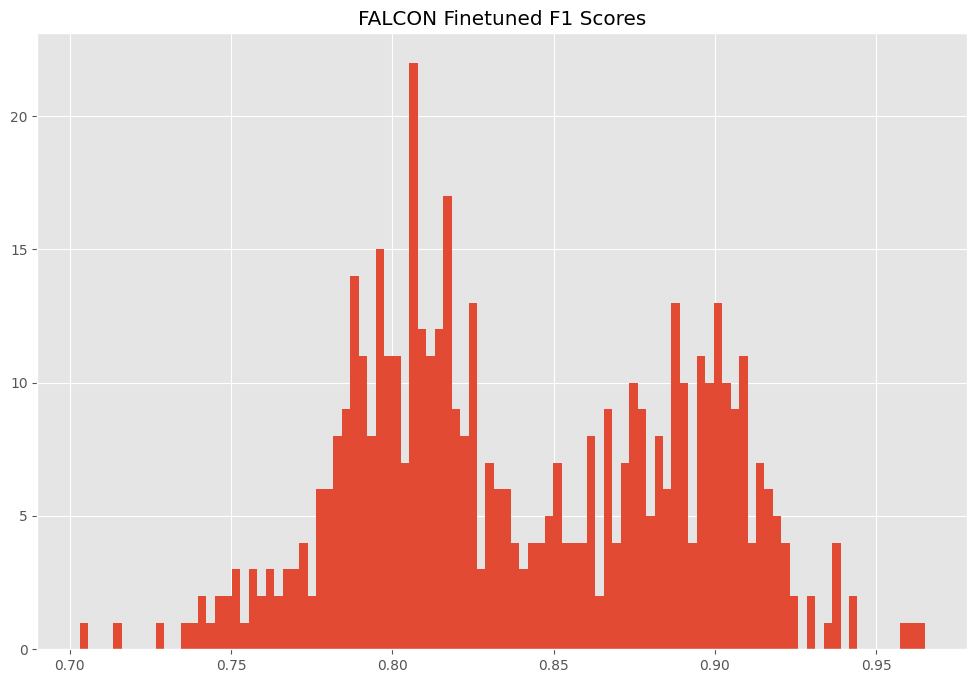

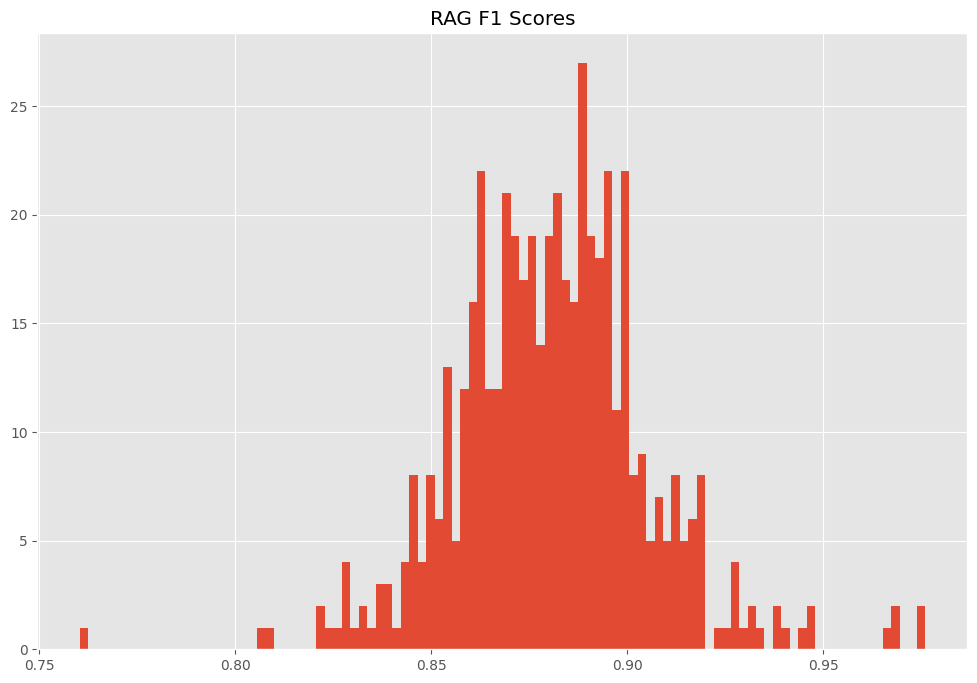

In [41]:
for model_name, results_df in models_with_results.items():
    show_f1_scores(results_df, model_name)

In [44]:
def show_average_scores(df, model_name):
    average_precision = df['P'].mean()
    average_recall = df['R'].mean()
    average_f1 = df['F1'].mean()

    scores = [average_precision, average_recall, average_f1]
    labels = ['Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(8, 6))
    barlist = plt.bar(labels, scores, color=['blue', 'green', 'red'])
    for idx, bar in enumerate(barlist):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{scores[idx]:.3f}', ha='center', va='bottom')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{model_name} Average Precision, Recall, and F1 Score')
    plt.style.use('ggplot')
    plt.show()

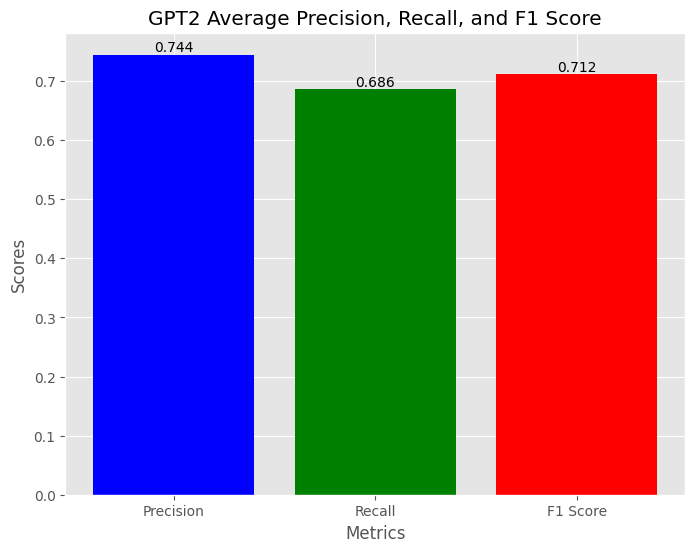

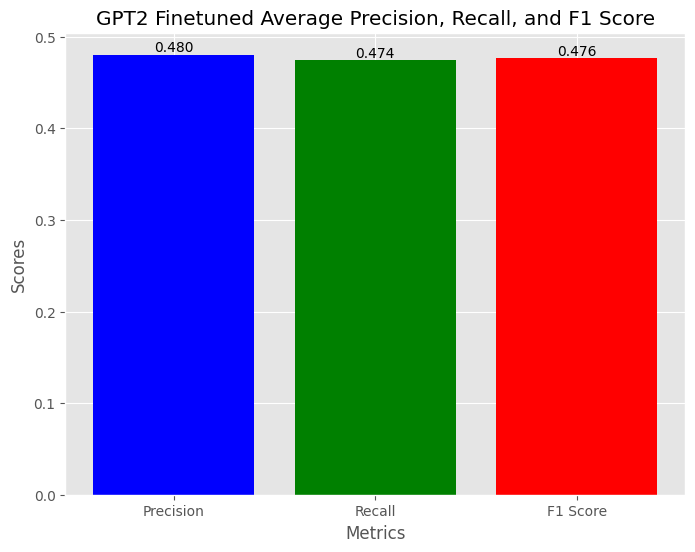

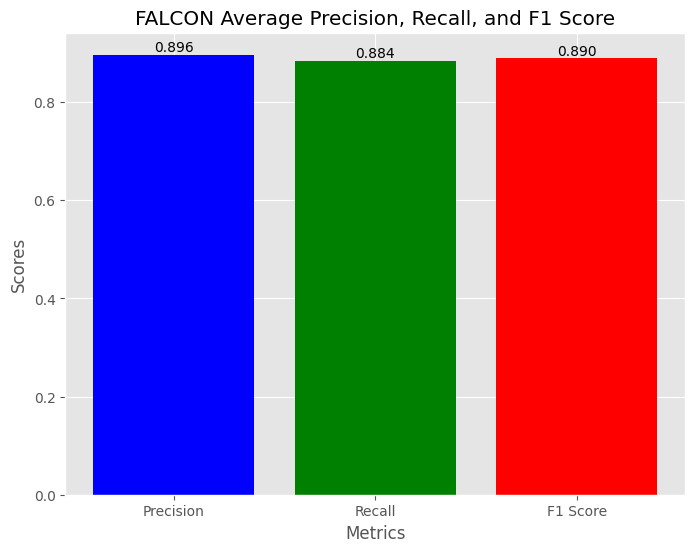

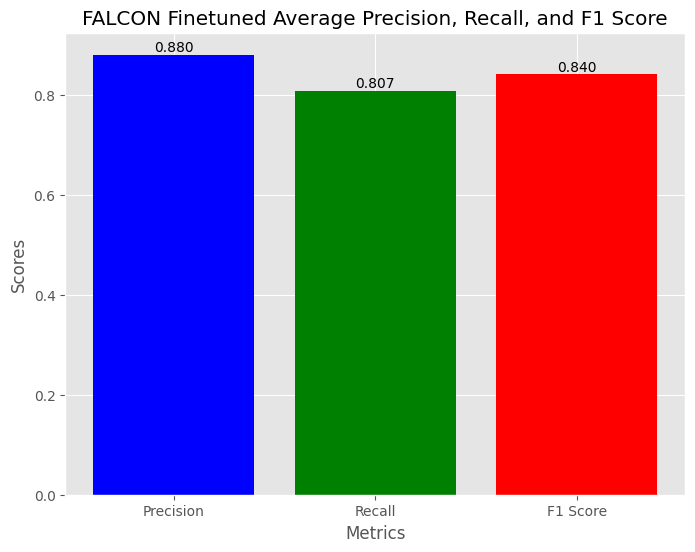

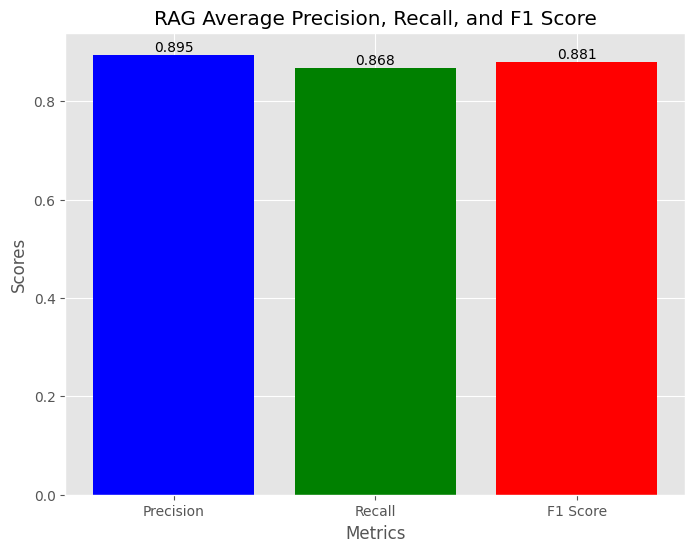

In [45]:

average_precision_gpt2 = gpt2_results_df['P'].mean()
average_recall_gpt2 = gpt2_results_df['R'].mean()
average_f1_gpt2 = gpt2_results_df['F1'].mean()

average_precision_gpt2_finetune = gpt2_finetune_results_df['P'].mean()
average_recall_gpt2_finetune = gpt2_finetune_results_df['R'].mean()
average_f1_gpt2_finetune = gpt2_finetune_results_df['F1'].mean()

average_precision_falcon = falcon_results_df['P'].mean()
average_recall_falcon = falcon_results_df['R'].mean()
average_f1_falcon = falcon_results_df['F1'].mean()

average_precision_falcon_finetune = falcon_finetune_results_df['P'].mean()
average_recall_falcon_finetune = falcon_finetune_results_df['R'].mean()
average_f1_falcon_finetune = falcon_finetune_results_df['F1'].mean()

average_precision_rag = rag_results_df['P'].mean()
average_recall_rag = rag_results_df['R'].mean()
average_f1_rag = rag_results_df['F1'].mean()


precisions = [average_precision_gpt2, average_precision_gpt2_finetune, average_precision_falcon, average_precision_falcon_finetune, average_precision_rag]
recalls = [average_recall_gpt2, average_recall_gpt2_finetune, average_recall_falcon, average_recall_falcon_finetune, average_recall_rag]
f1_scores = [average_f1_gpt2, average_f1_gpt2_finetune, average_f1_falcon, average_f1_falcon_finetune, average_f1_rag]



labels = ['GPT2', 'GPT2 Finetuned', 'Falcon 7B', 'Falcon 7B Finetuned', 'RAG']
x = np.arange(len(labels))
width = 0.2


fig, ax = plt.subplots(figsize=(12, 6))


rects1 = ax.bar(x - width, precisions, width, label='Precision', color='blue')
rects2 = ax.bar(x, recalls, width, label='Recall', color='green')
rects3 = ax.bar(x + width, f1_scores, width, label='F1', color='red')


ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1 Across Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)


plt.tight_layout()
plt.show()

In [ ]:
def calculate_accuracy(df):
    above_threshold = df['F1'] > 0.8

    accuracy_score = above_threshold.sum() / len(df)

    return accuracy_score


accuracy_gpt2 = calculate_accuracy(gpt2_results_df)
accuracy_gpt2_finetune = calculate_accuracy(gpt2_finetune_results_df)
accuracy_falcon = calculate_accuracy(falcon_results_df)
accuracy_falcon_finetune = calculate_accuracy(falcon_finetune_results_df)
accuracy_rag = calculate_accuracy(rag_results_df)


print("Accuracy GPT2:", accuracy_gpt2)
print("Accuracy Finetuned GPT2:", accuracy_gpt2_finetune)
print("Accuracy Falcon:", accuracy_falcon)
print("Accuracy Finetuned Falcon:", accuracy_falcon_finetune)
print("Accuracy RAG:", accuracy_rag)


In [ ]:


precisions = [average_precision_gpt2, average_precision_gpt2_finetune, average_precision_falcon, average_precision_falcon_finetune, average_precision_rag]
recalls = [average_recall_gpt2, average_recall_gpt2_finetune, average_recall_falcon, average_recall_falcon_finetune, average_recall_rag]
f1_scores = [average_f1_gpt2, average_f1_gpt2_finetune, average_f1_falcon, average_f1_falcon_finetune, average_f1_rag]
accuracies = [accuracy_gpt2, accuracy_gpt2_finetune, accuracy_falcon, accuracy_falcon_finetune, accuracy_rag]


labels = ['GPT2', 'Finetuned GPT2', 'Falcon 7B', 'Finetuned Falcon 7B', 'RAG']

x = np.arange(len(labels))
width = 0.15


fig, ax = plt.subplots(figsize=(15, 6))

rects1 = ax.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
rects2 = ax.bar(x - 0.5*width, recalls, width, label='Recall', color='green')
rects3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1', color='red')
rects4 = ax.bar(x + 1.5*width, accuracies, width, label='Accuracy', color='purple')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, F1, and Accuracy Across Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

plt.tight_layout()
plt.show()
